# City of L.A. Jobs

#### This Kernel was created in fulfillment of NYC Data Science Academy's Capstone Project. The accompanying presentation is available here:
(http://bit.ly/ds4g_la)

## Data Wrangling - Text

In [4]:
import pandas as pd
import numpy as np
import glob
import os
import re

##### Importing a modified version of this kernel, which devours our attempts to parse the txt files: 

In [5]:
# Function to read a single job posting
def read_job_posting(filename):
    # read all the files into memory
    with open(filename, 'r', errors='ignore') as fp:
        filetext = fp.readlines()
        filetext = [line.rstrip().replace('\t+','') for line in filetext if line.rstrip()]
    # concatenated file text
    concat_file_text = '\n'.join(filetext)
    
    # Extract Various Fields
    this_file_data = {'FILE_NAME': os.path.basename(filename, ),
                      'FILE_TEXT':concat_file_text,
                      'JOB_CLASS_TITLE':filetext[0].rstrip(),
                      'JOB_CLASS_NO': (re.findall(r'\d+',list(filter(lambda x: 'Class Code:' in x,filetext))[0])[0] 
                                       if len(list(filter(lambda x: 'Class Code:' in x,filetext))) > 0 else np.nan),
                      'OPEN_DATE': (list(filter(lambda x: 'Open Date:' in x,filetext))[0].split("Open Date:")[1].split("(")[0].strip() 
                                    if len(list(filter(lambda x: 'Open Date:' in x,filetext))) >0 else None),
                      'JOB_DUTIES': re.split(r'DUTIES\n*|\n*REQUIREMENT',concat_file_text)[1],
                      'ENTRY_SALARY_GEN': (re.split(r'\n+|;|and|or|The|\(|\. |, ',
                                                   re.split(r'ANNUAL SALARY\n*',concat_file_text)[1])[0]
                                                      .strip().replace('to','-').replace('TO','-').replace('flat rated.','(flat rated)') 
                                           if len(re.split(r'ANNUAL SALARY\n*',concat_file_text)) > 1 else None),
                      'ENTRY_SALARY_DWP': (re.split(r'\n+|;|and|or|The|\(|\. , ',(list(filter(lambda x: 'salary in the Department of Water and Power is' in x,filetext))[0]
                                            .split('Power is')[1]))[0]
                                            .strip().replace('to','-')
                                            .replace('flat rated.','(flat rated)') 
                                           if len(list(filter(lambda x: 'salary in the Department of Water and Power is' in x,filetext))) > 0 else np.nan),
                      'REQUIREMENTS': (re.split(r'\n*WHERE TO APPLY',(re.split(r'REQUIREMENTS?(?:\s*/\s*MINIMUM QUALIFICATIONS?)?\n*',concat_file_text)[1]))[0]
                                       if len(re.split(r'REQUIREMENTS?(?:\s*/\s*MINIMUM QUALIFICATIONS?)?',concat_file_text)) > 1 else None),
                     }
    
    # ENTRY_SALARY_GEN
    if this_file_data['ENTRY_SALARY_GEN'] is not None:
        if '$' not in this_file_data['ENTRY_SALARY_GEN']:
            this_file_data['ENTRY_SALARY_GEN'] = None
    try: 
        this_file_data['ENTRY_SALARY_AVG'] = (np.mean(list(map(float,re.sub('\$|,|\(*flat.*rated\)*|-|\*','',this_file_data['ENTRY_SALARY_GEN']).split()))))
    except Exception as e:
        this_file_data['ENTRY_SALARY_AVG'] = np.nan #if this_file_data['ENTRY_SALARY_GEN'] is not None else np.nan)                              

    
    if 'driver\'s license is required' in this_file_data['REQUIREMENTS']:
        this_file_data['HS_REQ'] = 1
    elif 'Graduation from a high school' in this_file_data['REQUIREMENTS']:
        this_file_data['HS_REQ'] = 1
    elif 'High School graduation Is desired but not required' in this_file_data['REQUIREMENTS']:
        this_file_data['HS_REQ'] = 0
    else:
        this_file_data['HS_REQ'] = 0
        
    if 'Graduation from a U.S. High School”' in this_file_data['REQUIREMENTS']:
        this_file_data['DRIVER_LICENSE_REQ'] = 'R'
    elif re.compile('driver\'s license').search(this_file_data['REQUIREMENTS']):
        this_file_data['DRIVER_LICENSE_REQ'] = 'P'
    else:
        this_file_data['DRIVER_LICENSE_REQ'] = ''
        
# EDUCATION_YEARS, SCHOOL TYPE, EDUCATION_MAJOR - from https://www.kaggle.com/schapke/working-in-la
    line = this_file_data['REQUIREMENTS']
    education = re.search('(?i).*(education)|(college)|(school)|(university).*', line)
    if education:
        edu_type = re.search('(?i)(university)|(college)|(school)', line)
        if 'college or university' in line.lower():
            this_file_data['SCHOOL_TYPE'] = 'COLLEGE OR UNIVERSITY'
        elif edu_type:
            this_file_data['SCHOOL_TYPE'] = edu_type[0].upper()

        major = re.search('((degree)|(major)) in(\s[A-Z]+\w*)+', line)
        if major:
            this_file_data['EDUCATION_MAJOR'] = re.search('(\s[A-Z]+\w*)+', major[0])[0].upper().strip()

        length = re.search('(?i)((\d+)|(\w)+).((semesters?)|(years?)|(months?)|(consecutive months?))', line)
        if length:
            this_file_data['EDUCATION_YEARS'] = length[0].upper().strip()

    # EXPERIENCE_LENGTH
    experience = re.search('(?i).*experience.*', line)
    if experience:

        length = re.search('(?i)((\d+)|(\w+)) ((consecutive months?)|(each year?)|(years?)|(months))', experience[0])
        if length:
            this_file_data['EXPERIENCE_LENGTH'] = length[0].upper().strip()


        time = re.search('(?i)((full)|(part))-?\s?time', experience[0])
        if time:
            this_file_data['FULL_TIME_PART_TIME'] = time[0].upper().strip()

    df = pd.DataFrame(this_file_data, index=[0])
    df['DRIV_LIC_TYPE'] = df.REQUIREMENTS.str.extract(r'(Class.*)\s+(driver\'s)\s*license?')[0].str.replace('\s*(driver\'s)?\s*license.*|\s*California\s*','')
   
    return(df)

In [6]:
#get file list
bulletin_dir = "./data/CityofLA/Job Bulletins"
filenames = glob.glob(bulletin_dir+'/*')

#read in data
data_list = []
for file_ in filenames:
    df = read_job_posting(file_)
    data_list.append(df)
        
#to DataFrame        
jobs_df = pd.concat(data_list, sort = False).reset_index(drop = True)


#lowercase columns for easier accessibility
jobs_df.columns = [x.lower() for x in jobs_df.columns]
jobs_df.to_csv("~/jobs_df.csv")

###### Check if Working 

In [7]:
jobs_df.columns

Index(['file_name', 'file_text', 'job_class_title', 'job_class_no',
       'open_date', 'job_duties', 'entry_salary_gen', 'entry_salary_dwp',
       'requirements', 'entry_salary_avg', 'hs_req', 'driver_license_req',
       'experience_length', 'full_time_part_time', 'driv_lic_type',
       'school_type', 'education_years', 'education_major'],
      dtype='object')

## Unsupervised Learning - Topic Modeling

In [8]:
# Run in python console
import nltk; nltk.download('stopwords')

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Importing Stopwords

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
duties = jobs_df.job_duties
data = duties

In [10]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
#Add Stop Word Extensions
stop_words.extend(['may', 'los', 'angeles', 'work', 'use', 'equal', 'opportunity', 'employment'])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### LDA

##### Functions to Evaluate LDA Models

In [16]:
def compute_LDAM_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



def compute_LDA_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize = 100, passes = 10, update_every = 1, alpha = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

##### Instantiate Initial Model

In [22]:
#Initial Params
num_topics = 10
random_state = 100
chunksize = 100
passes = 10
update_every = 1
alpha = 'auto'

In [23]:
# LDA Model creation
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           update_every=update_every,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.276094  0.137723       1        1  34.457779
1      0.224586 -0.055072       2        1  16.955351
4     -0.061542 -0.046035       3        1  13.340560
5      0.026489 -0.205474       4        1   9.671844
2     -0.144009 -0.048849       5        1   6.601825
8      0.102309 -0.106179       6        1   6.472202
0     -0.060222  0.285203       7        1   6.419852
7     -0.094514  0.077988       8        1   4.280515
9     -0.147146 -0.021186       9        1   1.484663
6     -0.122044 -0.018119      10        1   0.315410, topic_info=     Category        Freq          Term       Total  loglift  logprob
85    Default  236.000000     equipment  236.000000  30.0000  30.0000
49    Default  238.000000   maintenance  238.000000  29.0000  29.0000
5     Default  308.000000          city  308.000000  28.0000  28.0000
40    Default  121.000000    electrical  121.000000  27.0000  27.0000
4     Default  327.000000         build  327.000000  26.0000  26.0000
16    Default  391.000000      maintain  391.000000  25.0000  25.0000
28    Default  315.000000   supervisory  315.000000  24.0000  24.0000
25    Default  310.000000         sound  310.000000  23.0000  23.0000
9     Default  308.000000     effective  308.000000  22.0000  22.0000
29    Default  319.000000     technique  319.000000  21.0000  21.0000
61    Default  157.000000        repair  157.000000  20.0000  20.0000
31    Default  192.000000  construction  192.000000  19.0000  19.0000
92    Default  323.000000       perform  323.000000  18.0000  18.0000
14    Default  289.000000       fulfill  289.000000  17.0000  17.0000
13    Default  273.000000         force  273.000000  16.0000  16.0000
0     Default  340.000000         apply  340.000000  15.0000  15.0000
21    Default  307.000000     principle  307.000000  14.0000  14.0000
11    Default  262.000000        engage  262.000000  13.0000  13.0000
65    Default  228.000000       service  228.000000  12.0000  12.0000
103   Default  119.000000          fire  119.000000  11.0000  11.0000
12    Default  128.000000      facility  128.000000  10.0000  10.0000
58    Default  206.000000       program  206.000000   9.0000   9.0000
142   Default   85.000000     assistant   85.000000   8.0000   8.0000
117   Default  121.000000       control  121.000000   7.0000   7.0000
404   Default   81.000000          must   81.000000   6.0000   6.0000
586   Default  108.000000       airport  108.000000   5.0000   5.0000
202   Default   77.000000        police   77.000000   4.0000   4.0000
35    Default  258.000000        direct  258.000000   3.0000   3.0000
19    Default  279.000000          plan  279.000000   2.0000   2.0000
275   Default   89.000000      building   89.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2761  Topic10    0.387918       drydock    1.164323   4.6599  -5.6000
2763  Topic10    0.387918       rowboat    1.164323   4.6599  -5.6000
2861  Topic10    0.386613   nonelectric    1.163235   4.6575  -5.6033
2297  Topic10    0.231200     framework    1.007665   4.2869  -6.1175
2298  Topic10    0.231200   interrelate    1.007665   4.2869  -6.1175
2174  Topic10    0.229915        extend    1.008224   4.2808  -6.1230
1662  Topic10    0.142524  plasticizing    0.918919   3.8954  -6.6012
1659  Topic10    0.142524          mark    0.918919   3.8954  -6.6012
1153  Topic10    0.024761    preventive    0.821774   2.2568  -8.3515
1745  Topic10    0.024761   maintaining    0.827179   2.2503  -8.3515
1669  Topic10    0.024761      indexing    0.828873   2.2482  -8.3515
1765  Topic10    0.024761         kelly    0.830426   2.2464  -8.3515
1763  Topic10    0.024761        gantry    0.830426   2.2464  -8.3515
1766  Topic10    0.024761       propane    0.830426   2.2464  -8.3515
1799  Topic10    0.024761       walkway    0.830645   2.2461  -8.3515
1536  Topic10    0.

In [25]:
coherence_model_lda = CoherenceModel(
    model=lda_model, 
    texts=data_lemmatized, 
    dictionary=id2word, 
    coherence='c_v')



coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4173782930380046


In [26]:
###Initial Params
start = 5
limit = 40
step = 1

In [27]:
model_list, coherence_values = compute_LDA_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=data_lemmatized,
    start=start, 
    limit=limit, 
    step=step)

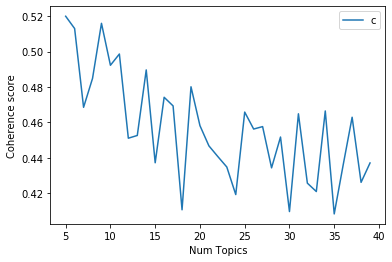

In [28]:
limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.52
Num Topics = 6  has Coherence Value of 0.513
Num Topics = 7  has Coherence Value of 0.469
Num Topics = 8  has Coherence Value of 0.485
Num Topics = 9  has Coherence Value of 0.516
Num Topics = 10  has Coherence Value of 0.492
Num Topics = 11  has Coherence Value of 0.499
Num Topics = 12  has Coherence Value of 0.451
Num Topics = 13  has Coherence Value of 0.453
Num Topics = 14  has Coherence Value of 0.49
Num Topics = 15  has Coherence Value of 0.437
Num Topics = 16  has Coherence Value of 0.474
Num Topics = 17  has Coherence Value of 0.469
Num Topics = 18  has Coherence Value of 0.411
Num Topics = 19  has Coherence Value of 0.48
Num Topics = 20  has Coherence Value of 0.458
Num Topics = 21  has Coherence Value of 0.447
Num Topics = 22  has Coherence Value of 0.441
Num Topics = 23  has Coherence Value of 0.435
Num Topics = 24  has Coherence Value of 0.419
Num Topics = 25  has Coherence Value of 0.466
Num Topics = 26  has Coherence Value of 0.

##### Running with Best Params

In [30]:
#Best Params
num_topics = 6
passes = 10
chunksize = 10
update_every = 1
alpha = 'auto'

In [31]:
# LDA Model creation
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           update_every=update_every,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)

##### Visualizing Clusters

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model2, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.301861 -0.173409       1        1  39.348122
2     -0.064688  0.211711       2        1  15.700264
0     -0.260033 -0.198966       3        1  14.026128
5      0.020039 -0.053906       4        1  12.362109
4      0.070091  0.217073       5        1  11.331999
3     -0.067271 -0.002502       6        1   7.231381, topic_info=     Category        Freq           Term       Total  loglift  logprob
85    Default  274.000000      equipment  274.000000  30.0000  30.0000
40    Default  178.000000     electrical  178.000000  29.0000  29.0000
16    Default  383.000000       maintain  383.000000  28.0000  28.0000
61    Default  185.000000         repair  185.000000  27.0000  27.0000
0     Default  368.000000          apply  368.000000  26.0000  26.0000
4     Default  353.000000          build  353.000000  25.0000  25.0000
29    Default  337.000000      technique  337.000000  24.0000  24.0000
28    Default  327.000000    supervisory  327.000000  23.0000  23.0000
25    Default  321.000000          sound  321.000000  22.0000  22.0000
9     Default  314.000000      effective  314.000000  21.0000  21.0000
14    Default  304.000000        fulfill  304.000000  20.0000  20.0000
13    Default  302.000000          force  302.000000  19.0000  19.0000
21    Default  300.000000      principle  300.000000  18.0000  18.0000
35    Default  270.000000         direct  270.000000  17.0000  17.0000
117   Default  111.000000        control  111.000000  16.0000  16.0000
49    Default  269.000000    maintenance  269.000000  15.0000  15.0000
103   Default  119.000000           fire  119.000000  14.0000  14.0000
115   Default  104.000000  communication  104.000000  13.0000  13.0000
275   Default  100.000000       building  100.000000  12.0000  12.0000
11    Default  244.000000         engage  244.000000  11.0000  11.0000
19    Default  236.000000           plan  236.000000  10.0000  10.0000
211   Default   98.000000          state   98.000000   9.0000   9.0000
66    Default  111.000000        station  111.000000   8.0000   8.0000
503   Default  110.000000            use  110.000000   7.0000   7.0000
92    Default  300.000000        perform  300.000000   6.0000   6.0000
65    Default  196.000000        service  196.000000   5.0000   5.0000
86    Default  214.000000       evaluate  214.000000   4.0000   4.0000
771   Default   70.000000       document   70.000000   3.0000   3.0000
404   Default   93.000000           must   93.000000   2.0000   2.0000
70    Default  196.000000         system  196.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
658    Topic6   21.844255        analyst   22.555553   2.5947  -4.7014
1207   Topic6   20.742908        auditor   21.444677   2.5935  -4.7531
1077   Topic6   21.096079          press   21.858246   2.5913  -4.7362
1811   Topic6   19.908165            pre   20.641146   2.5906  -4.7942
683    Topic6   18.888252       customer   19.585442   2.5905  -4.8468
1113   Topic6   18.698259         center   19.403715   2.5897  -4.8569
621    Topic6   17.722517     assistance   18.443073   2.5869  -4.9105
694    Topic6   17.119808       business   17.816008   2.5869  -4.9451
1219   Topic6   19.518488          audit   20.364954   2.5843  -4.8139
1524   Topic6   15.845963         social   16.547186   2.5834  -5.0224
1351   Topic6   15.776546        revenue   16.477224   2.5833  -5.0268
1717   Topic6   13.950728  real_property   14.648290   2.5780  -5.1498
688    Topic6   14.799303      interpret   15.556181   2.5769  -5.0907
588    Topic6   13.363252          asset   14.076712   2.5747  -5.1928
1975   Topic6   13.100076     investment   13.800037   2.5747  -5.2127
668    Topic6   13.136645    legislative   13.846511   2.5741  -5.2099
2477   Topic6   13.086643   photographer   13.802619   2.5735  -5.2137
1688   Topic6   12.409260        private   13.

### LDA Mallet Model

from https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [20]:
#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip ~/data/
#!unzip ~/data/mallet-2.0.8.zip 
mallet_path = '~/data/mallet-2.0.8/bin/mallet'

In [21]:
#Best Params
num_topics = 6
passes = 10
chunksize = 10
update_every = 1
alpha = 'auto'

In [22]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

##### Tuning Based on Coherence Scores

In [23]:
coherence_model_ldamallet = CoherenceModel(
    model=ldamallet, 
    texts=data_lemmatized, 
    dictionary=id2word, 
    coherence='c_v')

In [24]:
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5550713291635754


##### Checking best Coherence Values

In [23]:
###Initial Params
start = 4
limit = 25
step = 1
model = "Mallet"

In [24]:
#takes a long time - commented out for your safety
#model_list, coherence_values = compute_LDAM_coherence_values(
#    dictionary=id2word, 
#    corpus=corpus, 
#    texts=data_lemmatized,
#    start=start, 
#    limit=limit, 
#    step=step)

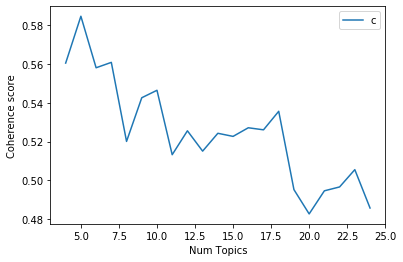

In [28]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 4  has Coherence Value of 0.561
Num Topics = 5  has Coherence Value of 0.585
Num Topics = 6  has Coherence Value of 0.558
Num Topics = 7  has Coherence Value of 0.561
Num Topics = 8  has Coherence Value of 0.52
Num Topics = 9  has Coherence Value of 0.543
Num Topics = 10  has Coherence Value of 0.547
Num Topics = 11  has Coherence Value of 0.513
Num Topics = 12  has Coherence Value of 0.526
Num Topics = 13  has Coherence Value of 0.515
Num Topics = 14  has Coherence Value of 0.524
Num Topics = 15  has Coherence Value of 0.523
Num Topics = 16  has Coherence Value of 0.527
Num Topics = 17  has Coherence Value of 0.526
Num Topics = 18  has Coherence Value of 0.536
Num Topics = 19  has Coherence Value of 0.495
Num Topics = 20  has Coherence Value of 0.483
Num Topics = 21  has Coherence Value of 0.495
Num Topics = 22  has Coherence Value of 0.497
Num Topics = 23  has Coherence Value of 0.506
Num Topics = 24  has Coherence Value of 0.486


##### Running with Best Params

In [28]:
#Params
num_topics = 15

#Run LDA Mallet3
ldamallet3 = gensim.models.wrappers.LdaMallet(
    mallet_path, 
    corpus=corpus,
    num_topics=num_topics, 
    id2word=id2word)

##### Visualizing Topics

In [29]:
lda_model3 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet3)


pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model3, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.111022 -0.195080       1        1  12.771181
14    -0.419309 -0.034720       2        1   6.881852
7      0.061382  0.046396       3        1   6.669421
8     -0.425819 -0.021213       4        1   6.657920
1      0.120758  0.202635       5        1   6.404691
2      0.111246 -0.291577       6        1   6.398192
5      0.092688  0.042236       7        1   6.197014
0      0.008162  0.168906       8        1   6.162617
12     0.055385  0.056940       9        1   6.149775
13     0.069536  0.035300      10        1   6.074539
3      0.037681  0.032025      11        1   6.064142
11    -0.034310  0.048684      12        1   5.980752
9      0.086323  0.082058      13        1   5.907370
10     0.072216 -0.270203      14        1   5.881727
4      0.053038  0.097614      15        1   5.798810, topic_info=     Category        Freq            Term       Total  loglift  logprob
70    Default  285.000000          system  285.000000  30.0000  30.0000
92    Default  353.000000         perform  353.000000  29.0000  29.0000
16    Default  375.000000        maintain  375.000000  28.0000  28.0000
4     Default  293.000000           build  293.000000  27.0000  27.0000
29    Default  285.000000       technique  285.000000  26.0000  26.0000
0     Default  302.000000           apply  302.000000  25.0000  25.0000
5     Default  340.000000            city  340.000000  24.0000  24.0000
28    Default  280.000000     supervisory  280.000000  23.0000  23.0000
19    Default  277.000000            plan  277.000000  22.0000  22.0000
25    Default  275.000000           sound  275.000000  21.0000  21.0000
9     Default  276.000000       effective  276.000000  20.0000  20.0000
21    Default  275.000000       principle  275.000000  19.0000  19.0000
85    Default  261.000000       equipment  261.000000  18.0000  18.0000
65    Default  279.000000         service  279.000000  17.0000  17.0000
31    Default  198.000000    construction  198.000000  16.0000  16.0000
14    Default  257.000000         fulfill  257.000000  15.0000  15.0000
35    Default  231.000000          direct  231.000000  14.0000  14.0000
53    Default  206.000000       operation  206.000000  13.0000  13.0000
13    Default  238.000000           force  238.000000  12.0000  12.0000
58    Default  218.000000         program  218.000000  11.0000  11.0000
30    Default  211.000000        activity  211.000000  10.0000  10.0000
61    Default  171.000000          repair  171.000000   9.0000   9.0000
11    Default  242.000000          engage  242.000000   8.0000   8.0000
33    Default  261.000000      department  261.000000   7.0000   7.0000
49    Default  233.000000     maintenance  233.000000   6.0000   6.0000
10    Default  234.000000        employee  234.000000   5.0000   5.0000
59    Default  246.000000          relate  246.000000   4.0000   4.0000
117   Default  129.000000         control  129.000000   3.0000   3.0000
75    Default  211.000000           water  211.000000   2.0000   2.0000
46    Default  199.000000         include  199.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
819   Topic15    7.479212          assure    7.479212   2.8475  -5.5524
791   Topic15    7.479212          cement    7.479212   2.8475  -5.5524
793   Topic15    7.479212          finish    7.479212   2.8475  -5.5524
1776  Topic15    7.479212       carpenter    7.479212   2.8475  -5.5524
1874  Topic15    6.410753         compost    6.410753   2.8475  -5.7066
2116  Topic15    5.342294         closure    5.342294   2.8475  -5.8889
485   Topic15   43.806813       structure   44.754725   2.8261  -3.7847
31    Topic15  188.048756    construction  198.296456   2.7945  -2.3278
108   Topic15   37.396059          street   38.343972   2.8225  -3.9430
855   Topic15   24.574553       complaint   25.644480   2.8049  -4.3628
370   Topic15  

### NMF

In [33]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

msw = text.ENGLISH_STOP_WORDS.union(['may', 'los', 'angeles', 'work', 'use','city'])

c_vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=msw, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
#data_vectorized = vectorizer.fit_transform(duties)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(use_idf=True, min_df=0.05, max_df=0.95, ngram_range=(1,1), sublinear_tf=True)

data_vectorized = tfidf.fit_transform(duties)

In [35]:
from sklearn.decomposition import NMF
from sklearn.decomposition.nmf import _beta_divergence 

In [36]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [37]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = tfidf.get_feature_names()
    
    topics = []
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        topics.append(words)
    return topics

##### Exploring Best Topic Counts for NMF using **Reconstruction Error**

In [56]:
#Takes a long time to run! Commented out
num_tops = range(4, 40, 1)
top_lis = []
rec_err_lis = []
for top in num_tops:
    nmf = NMF(n_components=top, random_state=0, alpha=.1, l1_ratio=.5).fit(data_vectorized)
    rec_err = nmf.reconstruction_err_
    print("Number of Topics:", top,"|" " Reconstruction error:", rec_err)

Number of Topics: 4 | Reconstruction error: 21.508965857412196
Number of Topics: 5 | Reconstruction error: 21.219858952950137
Number of Topics: 6 | Reconstruction error: 21.005299901612563
Number of Topics: 7 | Reconstruction error: 20.772179316363157
Number of Topics: 8 | Reconstruction error: 20.569133887858055
Number of Topics: 9 | Reconstruction error: 20.39767819909455
Number of Topics: 10 | Reconstruction error: 20.19437720580454
Number of Topics: 11 | Reconstruction error: 20.01698664262626
Number of Topics: 12 | Reconstruction error: 19.843469761189887
Number of Topics: 13 | Reconstruction error: 19.661566666564827
Number of Topics: 14 | Reconstruction error: 19.501410098537246
Number of Topics: 15 | Reconstruction error: 19.394196648394782
Number of Topics: 16 | Reconstruction error: 19.212123759344845
Number of Topics: 17 | Reconstruction error: 19.063865958690187
Number of Topics: 18 | Reconstruction error: 18.91951261945803
Number of Topics: 19 | Reconstruction error: 18.79

##### First NMF Attempt - 8 Topics

In [156]:
nmf8 = NMF(n_components=8, alpha=.1, l1_ratio=.5).fit(data_vectorized)

In [157]:
print_topics(nmf8, tfidf)

Topic 0:
[('assigns', 0.9282474890384279), ('evaluates', 0.9048310196104767), ('reviews', 0.8696271411752413), ('work', 0.7327669393803249), ('maintaining', 0.6717068948853204), ('force', 0.6558979969507887), ('supervisory', 0.6520877770739919), ('sound', 0.6362769433362556), ('engaged', 0.6362751656534739), ('building', 0.634892462902152)]
Topic 1:
[('may', 1.0859475926064512), ('to', 0.9828895511613858), ('as', 0.9784820481982449), ('be', 0.9464644567835437), ('required', 0.7263426305109842), ('or', 0.5733038117113354), ('on', 0.5306024851975963), ('are', 0.5279877561053584), ('in', 0.4521665905853692), ('lead', 0.45074725253777836)]
Topic 2:
[('equipment', 1.4380440933946093), ('repair', 1.2689825104195576), ('maintenance', 1.2599418442679502), ('construction', 0.6897215976377202), ('skilled', 0.674222340286905), ('electrical', 0.6673850033332992), ('of', 0.6221190135549048), ('installation', 0.5722139172879412), ('mechanical', 0.4647314214664635), ('in', 0.43322533976479194)]
Topic

##### Secopnd NMF Attempt - 11 Topics

In [38]:
nmf11 = NMF(n_components=11, alpha=.1, l1_ratio=.5).fit(data_vectorized)

In [39]:
nmf11.fit(data_vectorized)
print_topics(nmf11, tfidf)

Topic 0:
[('assigns', 0.9322883293857397), ('evaluates', 0.9075661414659508), ('reviews', 0.8715333793379118), ('work', 0.741954413576241), ('maintaining', 0.6746316366357394), ('force', 0.6609801426951241), ('supervisory', 0.6569618223552153), ('sound', 0.6406180837028895), ('building', 0.6397071502034215), ('engaged', 0.6382765862371038)]
Topic 1:
[('performs', 1.2030158760064675), ('related', 0.8741192148570691), ('does', 0.7540265437777707), ('work', 0.6757199049567114), ('duties', 0.6034928989523082), ('of', 0.5766760170262977), ('professional', 0.5309355460449093), ('personnel', 0.4882167646702648), ('administrative', 0.4750326258154964), ('in', 0.47141191715328107)]
Topic 2:
[('maintenance', 1.41123650789426), ('repair', 1.39465107943951), ('equipment', 1.3916433359617941), ('construction', 0.8369542450819139), ('of', 0.6184458777568594), ('installation', 0.6148467294571486), ('skilled', 0.5478776655930931), ('the', 0.4236181461770061), ('in', 0.3847890228568304), ('transportati

##### Visualizing with PyLDAvis (modified for use of NMF)

Modified PyLDAvis available at (https://github.com/mattsavoca/pyLDAvis)

In [64]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(nmf11, data_vectorized, tfidf, R=15, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      122.517059 -175.795410       1        1  16.836489
10      87.719452  -22.032270       2        1  13.462749
0     -197.992508  -98.772842       3        1  13.335898
1       77.171394  244.607956       4        1  10.686340
7     -102.122444  219.436676       5        1   9.741467
2      -41.587784 -188.411392       6        1   8.333622
4      -57.567406  -30.568798       7        1   6.385843
6      182.933243  117.074295       8        1   5.743915
5     -181.810486   75.122742       9        1   5.724958
8        5.347024  103.193649      10        1   5.568027
9      244.053436  -40.992283      11        1   4.180693, topic_info=    Category       Freq            Term      Total  loglift  logprob
142  Default  45.000000         systems  45.000000  15.0000  15.0000
154  Default  40.000000           water  40.000000  14.0000  14.0000
43   Default  32.000000      electrical  32.000000  13.0000  13.0000
8    Default  29.000000         angeles  29.000000  12.0000  12.0000
74   Default  29.000000             los  29.000000  11.0000  11.0000
49   Default  28.000000     engineering  28.000000  10.0000  10.0000
119  Default  30.000000          repair  30.000000   9.0000   9.0000
51   Default  41.000000       equipment  41.000000   8.0000   8.0000
77   Default  36.000000     maintenance  36.000000   7.0000   7.0000
84   Default  21.000000      mechanical  21.000000   6.0000   6.0000
26   Default  32.000000    construction  32.000000   5.0000   5.0000
16   Default  21.000000              be  21.000000   4.0000   4.0000
42   Default  22.000000        electric  22.000000   3.0000   3.0000
104  Default  20.000000           power  20.000000   2.0000   2.0000
99   Default  34.000000        performs  34.000000   1.0000   1.0000
96    Topic1  16.277806       organizes  16.277806   1.7816  -3.5170
37    Topic1  20.422548         directs  21.991291   1.7076  -3.2901
36    Topic1   5.117801       directing   6.851584   1.4899  -4.6740
161   Topic1   5.214482       workforce   7.768689   1.3830  -4.6553
20    Topic1   5.754334           chief   8.613166   1.3783  -4.5568
38    Topic1   7.819756        division  12.507336   1.3120  -4.2501
78    Topic1   5.275617           major   8.786938   1.2715  -4.6437
102   Topic1  15.865838           plans  27.050401   1.2481  -3.5426
2     Topic1   4.549910  administration   8.189072   1.1939  -4.7916
81    Topic1   4.762804         manager   8.594576   1.1913  -4.7459
1     Topic1  12.765614      activities  23.433429   1.1742  -3.7600
28    Topic1   5.818905     coordinates  11.028949   1.1422  -4.5456
70    Topic1   5.736606           large  11.116102   1.1201  -4.5599
41    Topic1  15.037624       effective  29.640671   1.1030  -3.5962
50    Topic1  14.597449           equal  28.900661   1.0986  -3.6259
..       ...        ...             ...        ...      ...      ...
30   Topic10   7.014894      department  26.899205   1.5441  -3.2522
79   Topic10   2.665005           makes  10.407770   1.5258  -4.2200
134  Topic10   2.550899         studies  11.804315   1.3561  -4.2638
91   Topic10   2.237078        operates  10.594709   1.3329  -4.3951
141  Topic10   2.493425          system  12.763185   1.2552  -4.2866
140  Topic10   1.710803         support   8.840263   1.2458  -4.6633
92   Topic10   3.426249       operation  17.982290   1.2302  -3.9688
53   Topic10   3.804751      facilities  20.357517   1.2109  -3.8640
63   Topic10   4.117887       including  23.038674   1.1663  -3.7849
90   Topic10   3.242656              on  30.106149   0.6598  -4.0239
87   Topic10   3.946388              of  78.774448  -0.1057  -3.8274
148  Topic10   3.548781              to  50.903763   0.2248  -3.9336
43   Topic11  32.359962      electrical  32.359962   3.1747  -1.4368
84   Topic11  17.081000      mechanical  21.377259   2.9503  -2.0757
61   Topic11   7.566553      

## After much discussion, we've determined our LDA Mallet model is our strongest Topic Model

## Sentiment Scores - LDA Model

In [40]:
def format_topics_sentences(ldamodel=lda_model3, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [41]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model3, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'LDA_Topic', 'LDA_Topic_Perc_Contrib', 'LDA_Keywords', 'Text']

# Show
#df_dominant_topic.head(15)

In [42]:
com_lis = []
for text in df_dominant_topic['Text']:
    mod = nmf11.transform(tfidf.transform([text]))[0]
    topp = float(mod.argmax(axis=0))
    com_lis.append(topp)
    

df_dominant_topic['NMF Topic'] = com_lis
df_dominant_topic.head(5)

,Document_No,LDA_Topic,LDA_Topic_Perc_Contrib,LDA_Keywords,Text,NMF Topic
0,0,0.0,0.1780,"plan, professional, engineering, project, desi...",A Landscape Architect oversees and prepares pr...,3.0
1,1,7.0,0.1909,"equipment, repair, maintenance, electrical, el...","An Electrical Services Manager plans, directs,...",3.0
2,2,14.0,0.1458,"engage, force, apply, maintain, supervisory, e...",A Wastewater Treatment Mechanic Supervisor ass...,0.0
3,3,14.0,0.1527,"engage, force, apply, maintain, supervisory, e...",An Equipment Repair Supervisor supervises the ...,2.0
4,4,0.0,0.1238,"plan, professional, engineering, project, desi...",A Building Electrical Engineer supervises and ...,9.0


In [43]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#instantiating SentimentIntesintyAnalyzer
analyzer = SentimentIntensityAnalyzer()
ldascore_lis = []

#polarity scores
for text in df_dominant_topic['Text']:
    vs = analyzer.polarity_scores(text)
    ldascore_lis.append(vs)

In [44]:
neg_lis = []
neu_lis = []
pos_lis = []
comp_lis = []

for dic in ldascore_lis:
    neg_lis.append(dic["neg"])
    neu_lis.append(dic["neu"])
    pos_lis.append(dic["pos"])
    comp_lis.append(dic["compound"])

df_dominant_topic['lda_vader_neg'] = neg_lis
df_dominant_topic['lda_vader_neu'] = neu_lis
df_dominant_topic['lda_vader_pos'] = pos_lis
df_dominant_topic['lda_vader_compound'] = comp_lis

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#instantiating SentimentIntesintyAnalyzer
analyzer = SentimentIntensityAnalyzer()
nmfscore_lis = []

#polarity scores
for text in df_dominant_topic['Text']:
    vs = analyzer.polarity_scores(text)
    nmfscore_lis.append(vs)
    
df_dominant_topic.head()

,Document_No,LDA_Topic,LDA_Topic_Perc_Contrib,LDA_Keywords,Text,NMF Topic,lda_vader_neg,lda_vader_neu,lda_vader_pos,lda_vader_compound
0,0,0.0,0.1780,"plan, professional, engineering, project, desi...",A Landscape Architect oversees and prepares pr...,3.0,0.000,0.819,0.181,0.8625
1,1,7.0,0.1909,"equipment, repair, maintenance, electrical, el...","An Electrical Services Manager plans, directs,...",3.0,0.000,0.882,0.118,0.9169
2,2,14.0,0.1458,"engage, force, apply, maintain, supervisory, e...",A Wastewater Treatment Mechanic Supervisor ass...,0.0,0.000,0.872,0.128,0.8625
3,3,14.0,0.1527,"engage, force, apply, maintain, supervisory, e...",An Equipment Repair Supervisor supervises the ...,2.0,0.075,0.732,0.194,0.7783
4,4,0.0,0.1238,"plan, professional, engineering, project, desi...",A Building Electrical Engineer supervises and ...,9.0,0.026,0.869,0.105,0.7351


Text(0, 0.5, 'Contribution Percentage')

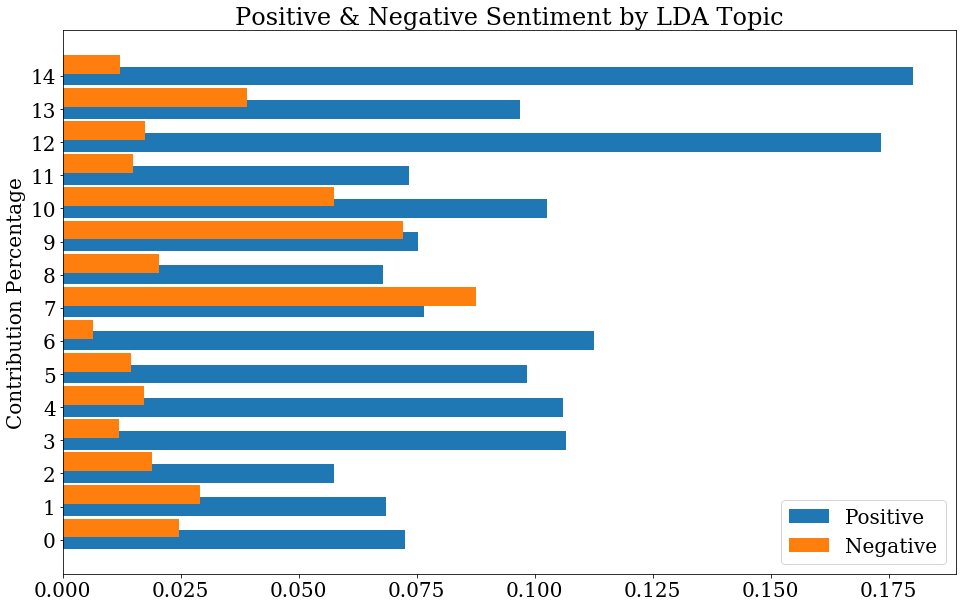

In [111]:
lda_topics_df = df_dominant_topic.groupby('LDA_Topic').mean()
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
plt.rc('font', family='serif', size=20)


plt.barh(y = lda_topics_df.index.values, width = lda_topics_df['vader_pos']*10, height = .57, label = 'Positive')
plt.barh(y = lda_topics_df.index.values + .35, width= lda_topics_df['lda_vader_neg'], height = .57, label='Negative')
plt.yticks(np.arange(15))
plt.legend(loc='best')
plt.title('Positive & Negative Sentiment by LDA Topic')
plt.ylabel('Topic')
plt.ylabel('Contribution Percentage')

In [46]:
df_dominant_topic.groupby('LDA_Keywords').mean().sort_values('LDA_Topic')[['LDA_Topic']]

,LDA_Topic
LDA_Keywords,
"plan, professional, engineering, project, design, perform, technical, development, engineer, preparation",0.0
"water, perform, report, environmental, material, prepare, analysis, supervise, conduct, research",1.0
"program, city, department, public, develop, safety, regulation, policy, procedure, community",2.0
"system, control, information, communication, datum, computer, traffic, processing, analyze, electronic",3.0
"construction, building, supervise, inspection, inspect, installation, maintenance, structure, mechanical, inspector",4.0
"operate, equipment, operator, require, water, treatment, position, high, work, make",5.0
"fire, candidate, application, department, city, shift, class, test, require, time",6.0
"equipment, repair, maintenance, electrical, electric, skilled, worker, mechanic, installation, crew",7.0
"direct, build, technique, sound, supervisory, principle, apply, effective, maintain, fulfill",8.0


## Our Findings within our Best Topic Model

- Ads in the “Supervisory” and “Systems” clusters have distanced language from the rest of the job ads.
- The word “maintain” as a near-antonym to the word “innovate”
- The pervasiveness of neutrality
- Limit multi-year vocational requirements for jobs with starting salaries below the LA poverty line (~58,000 year)


## Readability Scores

- ‘Syllable_Count’:				Total number of syllables in the text
- ‘Difficult_Words’:				Words >= 3 syllables

#### Multiple U.S. school “Grade-Level” Approximations:
- ‘Flesch_Reading_Ease’: 			Scaled: 100 (easiest) - 0 (most difficult)
- ‘Flesch_Kinkaid_Grade’:			9.1 refers to 9th grade reading level
- ‘Gunning_Fog_Index’:			9.1 refers to 9th grade reading level
- ‘SMOG_Index’:				9.1 refers to 9th grade reading level
- ‘Automated_Readability_Index’:		9.5  refers to 9th-10th grade reading level
- ‘Coleman_Liau_Index’:			9.1 refers to 9th grade reading level
- ‘Linsear_Write_Formula’:			9.1 refers to 9th grade reading level
- ‘Dale_Chall_Readability’:			Scaled: 1.0  (1st Grade) - 9.9 (College reading level)
------------------------------
- ‘Text_Standard’:				A weighted combination of all “Grade-Level”  metrics.


In [9]:
import textstat as ts

In [10]:
def get_readability_scores(df, col):
    import warnings
    warnings.filterwarnings("ignore")
    df['flesch_reading_ease'] = df[col].apply(ts.flesch_reading_ease)
    df['smog'] = df[col].apply(ts.smog_index)
    df['flesch_kincaid'] = df[col].apply(ts.flesch_kincaid_grade)
    df['coleman_liau'] = df[col].apply(ts.coleman_liau_index)
    df['auto_readability'] = df[col].apply(ts.automated_readability_index)
    df['dale_chall_readability'] = df[col].apply(ts.dale_chall_readability_score)
    df['difficult_words'] = df[col].apply(ts.difficult_words)
    df['linsear_write'] = df[col].apply(ts.linsear_write_formula)
    df['gunning_fog'] = df[col].apply(ts.gunning_fog)
    df['text_standard'] = df[col].apply(ts.text_standard)

In [11]:
jobs_df['duties_and_req'] = jobs_df.job_duties + jobs_df.requirements

get_readability_scores(jobs_df, 'duties_and_req')

In [49]:
jobs_df.sort_values('difficult_words', ascending = False)[['job_class_title', 'difficult_words']].head()

,job_class_title,difficult_words
315,FIRE HELICOPTER PILOT,249
9,FIRE INSPECTOR,247
678,APPARATUS OPERATOR,235
43,FIRE BATTALION CHIEF,232
674,FIRE ASSISTANT CHIEF,213


In [50]:
jobs_df.sort_values('auto_readability', ascending = False)[['job_class_title', 'auto_readability']].head()

,job_class_title,auto_readability
400,BACKGROUND INVESTIGATION MANAGER,73.9
501,FIREBOAT MATE,55.7
161,SENIOR UTILITY SERVICES SPECIALIST,47.7
90,CHIEF CLERK PERSONNEL,46.4
182,FIREBOAT PILOT,42.9


In [51]:
jobs_df.sort_values('text_standard', ascending = False)[['job_class_title', 'text_standard' ,'difficult_words']].head(10)

,job_class_title,text_standard,difficult_words
400,BACKGROUND INVESTIGATION MANAGER,58th and 59th grade,60
90,CHIEF CLERK PERSONNEL,38th and 39th grade,29
161,SENIOR UTILITY SERVICES SPECIALIST,38th and 39th grade,95
182,FIREBOAT PILOT,33rd and 34th grade,71
669,ASSISTANT AIRPORT MANAGER,32nd and 33rd grade,98
372,CHIEF ELECTRIC PLANT OPERATOR,32nd and 33rd grade,54
108,PRINCIPAL MECHANICAL ENGINEERING DRAFTING TECH...,30th and 31st grade,43
32,UTILITY EXECUTIVE SECRETARY,30th and 31st grade,107
637,CHIEF OF DRAFTING OPERATIONS,29th and 30th grade,53
512,INDUSTRIAL CHEMIST,28th and 29th grade,77


In [59]:
jobs_df['text_grade_level'] = [re.findall('[0-9]+', x)[0] for x in jobs_df.text_standard]

In [60]:
jobs_df.sort_values('text_grade_level', ascending = False)[['job_class_title', 'text_grade_level' ,'difficult_words']].head(100)

,job_class_title,text_grade_level,difficult_words
400,BACKGROUND INVESTIGATION MANAGER,58,60
90,CHIEF CLERK PERSONNEL,38,29
161,SENIOR UTILITY SERVICES SPECIALIST,38,95
182,FIREBOAT PILOT,33,71
669,ASSISTANT AIRPORT MANAGER,32,98
372,CHIEF ELECTRIC PLANT OPERATOR,32,54
108,PRINCIPAL MECHANICAL ENGINEERING DRAFTING TECH...,30,43
32,UTILITY EXECUTIVE SECRETARY,30,107
637,CHIEF OF DRAFTING OPERATIONS,29,53
512,INDUSTRIAL CHEMIST,28,77


In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

grade_level_df = jobs_df.groupby('text_grade_level').mean()
grade_level_df.reset_index()
grade_level_df.sample(5)

,entry_salary_avg,hs_req,flesch_reading_ease,smog,flesch_kincaid,coleman_liau,auto_readability,dale_chall_readability,difficult_words,linsear_write,gunning_fog
text_grade_level,,,,,,,,,,,
26,95126.142857,0.428571,-4.522857,23.728571,25.971429,16.948571,31.014286,10.504286,102.714286,47.571429,26.952857
30,88222.500000,0.000000,-18.840000,13.600000,30.750000,18.525000,37.500000,12.275000,75.000000,60.250000,33.135000
10,73890.333333,0.666667,51.263333,13.433333,10.366667,12.216667,12.300000,7.673333,43.000000,9.320106,11.920000
11,82419.666667,0.333333,42.443333,15.300000,12.400000,13.513333,14.533333,7.803333,72.666667,10.482143,12.833333
19,97971.779412,0.342857,15.730714,19.811429,19.270000,16.349429,22.717143,9.475429,88.200000,47.174048,20.035571


<BarContainer object of 26 artists>

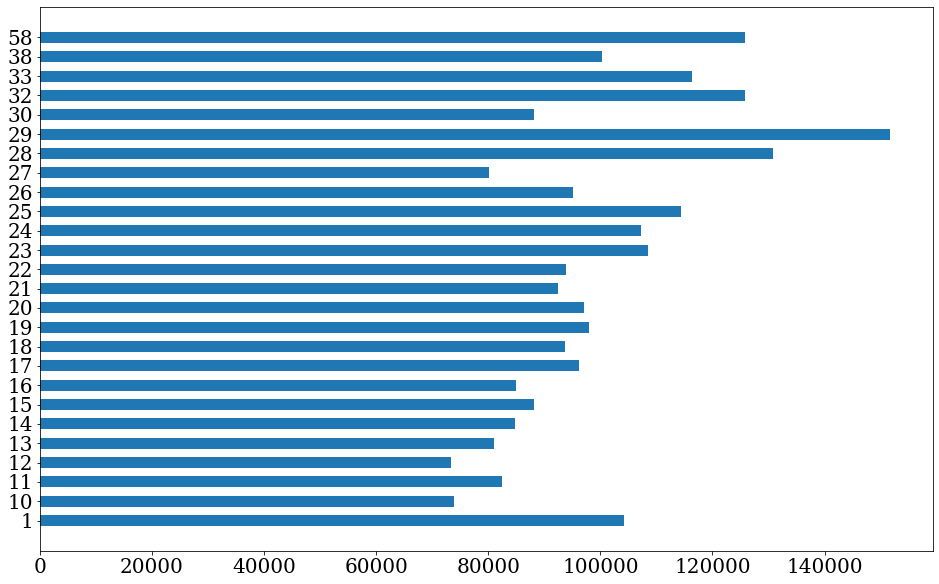

In [90]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
plt.rc('font', family='serif', size=20)


plt.barh(y = grade_level_df.index.values, width = grade_level_df['entry_salary_avg'], height = .57)

## (Re)defining Format: 
#### Changing Job Information dissemination

- Current Format of Ads is designed for maximum information, NOT ease of understanding.
- We assert that the ads appear made-for dissemination on paper or on government websites only.
- Many Millenials/Gen-Z  have “jobs find them where they already are”
- Organizations have begun effectively utilizing social media content to increase the number of individuals exposed to a particular job ad.
- Generally, ads for entry-level roles are particularly suited to being disseminated on 21st century mediums, i.e. Video on Social Media 


##### A Solution...

## Creating Social-Media ready job ads with BERT and MoviePy

In [12]:
from moviepy.editor import *
from summarizer import SingleModel
import pandas as pd
import re

In [54]:
solo_job = jobs_df.loc[:0,:]
solo_job

,file_name,file_text,job_class_title,job_class_no,open_date,job_duties,entry_salary_gen,entry_salary_dwp,requirements,entry_salary_avg,...,flesch_reading_ease,smog,flesch_kincaid,coleman_liau,auto_readability,dale_chall_readability,difficult_words,linsear_write,gunning_fog,text_standard
0,LANDSCAPE ARCHITECT 7929 090718.txt,LANDSCAPE ARCHITECT\n\t\t\t\t\t ...,LANDSCAPE ARCHITECT,7929,09-07-18,A Landscape Architect oversees and prepares pr...,"$89,638 - $131,064",NaN,Two years of full-time paid professional lands...,110351.0,...,4.18,21.6,22.9,17.71,27.6,10.47,50,19.75,24.76,22nd and 23rd grade


In [58]:
def create_job_ad_video(df, display = False):
    df = pd.DataFrame(df)
    for i in range(len(df)):
        # get job title
        title = "The city of Los Angeles is hiring a %s." % df['job_class_title'][i].title()
        
        # split/output job duties
        body = df['job_duties'][i]
        body1 = body.replace(";", ".").split()
        body2 = list(i + '\n' * (N % 3 == 2) for N, i in enumerate(body1))
        body3 = ' '.join(map(str, body2))
        model = SingleModel()
        result = model(body3, ratio=0.001, min_length = 90)
        duty = ''.join(result)
        
        # split/output job requirements
        body = df['requirements'][i]
        body1 = body.replace(";", ".").split()
        body2 = list(i + '\n' * (N % 3 == 2) for N, i in enumerate(body1))
        body3 = ' '.join(map(str, body2))
        result = model(body3, ratio=0.001, min_length = 60)
        reqs = ''.join(result)
        reqs = "Requirements: %s" % reqs
        
        # concatenate text sections
        title_txt = (TextClip(title, color='gold', font="Arial-bold", stroke_color='black', fontsize=60, kerning=-2).set_duration(5).set_position("center"))
        duty_txt = (TextClip(duty, color='gold', font="Arial-bold", stroke_color='black', fontsize=60, kerning=-2).set_duration(5).set_position("center"))
        req_txt = (TextClip(reqs, color='gold', font="Arial-bold", stroke_color='black', fontsize=60, kerning=-2).set_duration(5).set_position("center"))
        app_txt = (TextClip("Apply now at lacity.org", color='gold', font="Arial-bold", stroke_color='black', fontsize=60, kerning=-2).set_duration(5).set_position("center"))
        
        # add bg audio clip
        audioclip = AudioFileClip("./movie/Beach - MBB.mp3").set_duration(30)
        
        # add bg video clips
        clip1 = VideoFileClip("./movie/Beach.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        clip2 = VideoFileClip("./movie/Office.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        clip3 = VideoFileClip("./movie/Sunset.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        clip4 = VideoFileClip("./movie/Working.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        clip5 = VideoFileClip("./movie/Coastline.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        clip6 = VideoFileClip("./movie/Sea.mp4").resize(height=1000, width=1000).volumex(0).set_duration(5)
        
        # create each video "scene"
        pt1 = (CompositeVideoClip([clip1, title_txt])).set_duration(5)
        pt2 = (CompositeVideoClip([clip2, duty_txt])).set_duration(5)
        pt3 = (CompositeVideoClip([clip3, duty_txt])).set_duration(5)
        pt4 = (CompositeVideoClip([clip4, req_txt])).set_duration(5)
        pt5 = (CompositeVideoClip([clip5, req_txt])).set_duration(5)
        pt6 = (CompositeVideoClip([clip6, app_txt])).set_duration(5)
        
        # concatenate clip
        final_clip = concatenate_videoclips([pt1, pt2, pt3, pt4, pt5, pt6]).set_audio(audioclip)
        
        # write to file
        final_clip.write_videofile("%s_ad.mp4" % df['job_class_title'][i].title())
        
        #display options
        if display:
            clip = final_clip.ipython_display(width=500)
            done = clip
        else:
            done = 'Done'
        i += 1
        return done

In [60]:
create_job_ad_video(solo_job)

2it [00:00,  6.31it/s]
5it [00:00,  5.73it/s]
chunk:   0%|          | 0/662 [00:00<?, ?it/s, now=None]

Moviepy - Building video Landscape Architect_ad.mp4.
MoviePy - Writing audio in %s


t:   0%|          | 0/1500 [00:00<?, ?it/s, now=None]              

MoviePy - Done.
Moviepy - Writing video Landscape Architect_ad.mp4



Moviepy - Done !
Moviepy - video ready Landscape Architect_ad.mp4


'Done'

## Proof of Concept Video

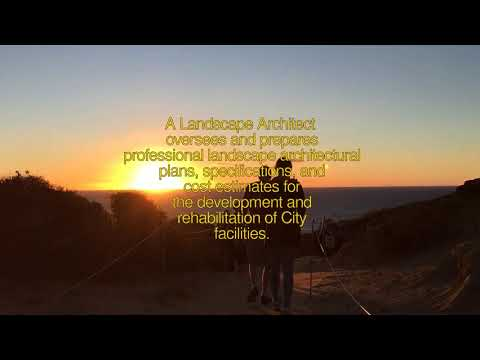

In [3]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('xqWlsXamNEI')

## Suggestions/Conclusions

## (Re)defining Format: 
### Text Sub-Categories, Information Dissemination, or both?


**Current sub-categorization of text:**
- Title
- Salary Range
- Duties
       Activities common to the job
- Requirements
        Educational & Vocational needs for consideration
- Notes
        Clarifications and (sometimes superfluous) information


**Proposed Re-categorization of text:**
- Title
- Salary Range
- Mission: 1-3 sentence “mission statement” of the job.
- Objective: Shift “Duties” to quantifiable, role-based goals, i.e. “improve attendance at city park events by 10% in six months”
- Necessities: Requirements to excel at the job AND to excel as a part of a thriving company culture.

*Re-categorization Source:  “Who”, Geoff Smart and Randy Street, Random House LLC, 2009*

## Questions for Job Ad Writers to ask themselves.

- Is the job’s mission clearly defined?
- Are the job’s listed requirements and duties necessary, true,  fair, inclusive, and accepting of all people?
- Do the job’s necessities embody cultural fit instead of (simply) vocational fit?
- Where and how is the job’s availability being communicated?
- Who will communicate the job’s availability?
